tgb - 10/2/2019 - This notebook aims at developing python script to automatize the calculation of the moist margin's length over 18 years of reanalysis data. Heavily inspired from https://github.com/tbeucler/2019_WMI/blob/master/dev/tbeucler/007_Select_ITCZ_cases.ipynb

In [62]:
# Choose year over which to calculate the contour length
year = 2003
YEAR = range(2000,2017)

In [63]:
import sys
sys.path.insert(0, "/users/jwindmil/2019_WMI/util")

# Initial imports
import Landau_Potential_Diffusion as Landau
import curvature as curve

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import datetime
from skimage import measure
from scipy import ndimage
import scipy.integrate as sin
from scipy.optimize import curve_fit

import pickle
import sys

In [64]:
# Open PW dataset
path = '/project/s916/ERA5_Tom/'
PW = xr.open_mfdataset(path+'%i/??PW.nc'%year,combine='by_coords')

In [65]:
# Restrict to Tropical Atlantic MSE field
dx = 110/4 #km
dt = 3600
tcoor = dt*np.arange(0,PW.time.shape[0])
latmin = -30
latmax = 30
lonmin = 300
lonmax = 360

PWAtl = PW['tcwv'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})
lonAtl = PW.longitude.sel({'longitude':slice(lonmin,lonmax)})
latAtl = PW.latitude.sel({'latitude':slice(latmax,latmin)})

In [66]:
PWAtl_np = PWAtl.values

percentile  83 test 46.510677337646484
corresponding PW value for median 32.763725


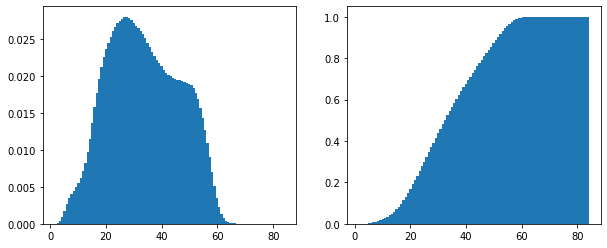

In [67]:
plt.figure(figsize=(10,4))
plt.subplot(121)
hist_info = plt.hist(np.ndarray.flatten(PWAtl_np), 100, density = True)
plt.subplot(122)
cum_info = plt.hist(np.ndarray.flatten(PWAtl_np), 100, density = True, cumulative = True)

# Calculate percentile corresponding to PW threshold
pw_thresh = 48.0
per_thresh_calc = int(100.0*cum_info[0][np.argmin(np.abs(cum_info[1]-pw_thresh))])
print('percentile ', per_thresh_calc, 'test', np.percentile(np.ndarray.flatten(PWAtl_np), per_thresh))

pw_median = np.median(np.ndarray.flatten(PWAtl_np))
print('corresponding PW value for median', pw_median)

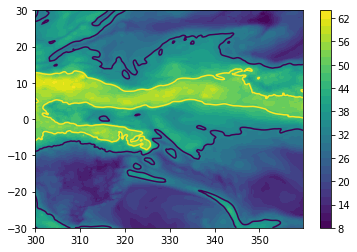

In [68]:
# Randomly chosen sample showing the difference between median and 48mm choice
ind_test = 4000
plt.contourf(lonAtl, latAtl, PWAtl_np[ind_test, :,:], 30)
plt.colorbar()
plt.contour(lonAtl, latAtl, PWAtl_np[ind_test,:,:], levels = [pw_median, pw_thresh])

In [69]:
# Open MSE dataset
path = '/project/s916/ERA5_Tom/'
MSE = xr.open_mfdataset(path+'%i/??MSE.nc'%year,combine='by_coords')

In [70]:
# Restrict to Tropical Atlantic MSE field
dx = 110/4 #km
dt = 3600
tcoor = dt*np.arange(0,MSE.time.shape[0])
latmin = -30
latmax = 30
lonmin = 300
lonmax = 360

MSEAtl = MSE['p62.162'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})
lonAtl = MSE.longitude.sel({'longitude':slice(lonmin,lonmax)})
latAtl = MSE.latitude.sel({'latitude':slice(latmax,latmin)})

In [71]:
MSEAtl_np = MSEAtl.values

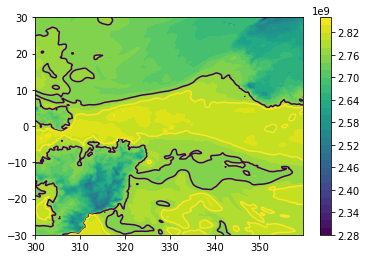

In [72]:
ind_test = 1000
plt.contourf(lonAtl, latAtl, MSEAtl_np[ind_test, :,:], 30)
plt.colorbar()
plt.contour(lonAtl, latAtl, MSEAtl_np[ind_test,:,:], levels = [np.percentile(MSEAtl_np[ind_test,:,:], 50), np.percentile(MSEAtl_np[ind_test,:,:], per_thresh)])


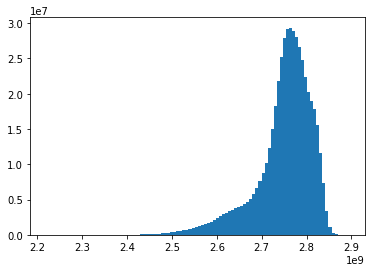

In [73]:
plt.hist(np.ndarray.flatten(MSEAtl_np), 100)
print('')

In [74]:
# Find index of a given date
def index_date(time_array,date_string):
    return [i for i, x in enumerate(time_array.sel({'time':date_string})==time_array) if x]

In [75]:
per_thresh = 80
# Iterate over years to calculate total contour length
L_CONTOUR = {}
it_tot = 0
print('year=',year)
date1 = str(year)+'-01-01T00:00:00'
date2 = str(year)+'-12-31T23:00:00'
it_tot = index_date(MSEAtl.time,date1)[0]
Nt = MSEAtl.time.sel({'time':slice(date1,date2)}).shape[0]
L_CONTOUR[str(year)] = np.zeros((Nt,))
for it in range(Nt):
    print('it=',it,' & it_tot=',it_tot,'               ',end='\r')
    MSE_tmp = MSEAtl[it_tot,:,:]
#     Contour = curve.get_contours(MSE_tmp>np.percentile(MSE_tmp,80))
#     L = 0
#     for j,contour in enumerate(Contour):
#         plt.plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='k')
#         L += np.sum(contour*dx)

    MSE_binary = np.zeros(np.shape(MSE_tmp))
    MSE_binary[MSE_tmp>np.percentile(MSE_tmp, per_thresh)] = 1

    binary_boundary=np.copy(MSE_binary)
    binary_boundary[:,1:-1]=0

    L = dx*(measure.perimeter(MSE_binary,8)- np.sum(binary_boundary))
        
    L_CONTOUR[str(year)][it] = L
    it_tot+=1

year= 2003


In [81]:
#### Save the contour length in a pickle file
path_PKL = '/users/jwindmil/2019_WMI/dev/jwindmiller/PKL_DATA/'
hf = open(path_PKL+'10_2_CONTOURL_%i'%(per_thresh)+str(year)+'.pkl','wb')
CONdata = {"Tot_Contour_km":L_CONTOUR,"time":MSEAtl.time}
pickle.dump(CONdata,hf)
hf.close()

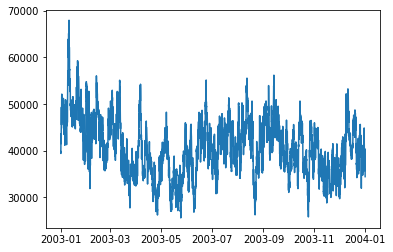

In [76]:
plt.plot(MSEAtl.time.values, L_CONTOUR['%i'%year])

In [77]:
# Calculate index
area_mse_field = np.size(MSEAtl_np[0,:,:])
min_circumference = 2.0*np.sqrt(area_mse_field*(80/100.0)*np.pi)*dx

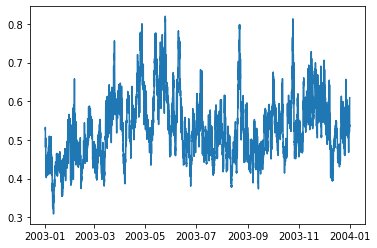

In [78]:
plt.plot(MSEAtl.time.values, min_circumference/L_CONTOUR['%i'%year])

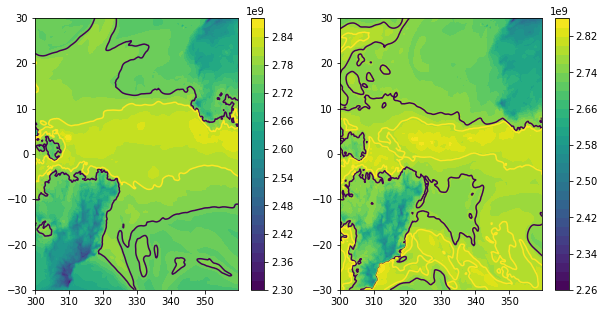

In [79]:
plt.figure(figsize=(10,5))
plt.subplot(121)
ind_test = np.argmin(L_CONTOUR['%i'%year])
plt.contourf(lonAtl, latAtl, MSEAtl_np[ind_test, :,:], 30)
plt.colorbar()
plt.contour(lonAtl, latAtl, MSEAtl_np[ind_test,:,:], levels = [np.percentile(MSEAtl_np[ind_test,:,:], 50), np.percentile(MSEAtl_np[ind_test,:,:], per_thresh)])

plt.subplot(122)
ind_test = np.argmax(L_CONTOUR['%i'%year])
plt.contourf(lonAtl, latAtl, MSEAtl_np[ind_test, :,:], 30)
plt.colorbar()
plt.contour(lonAtl, latAtl, MSEAtl_np[ind_test,:,:], levels = [np.percentile(MSEAtl_np[ind_test,:,:], 50), np.percentile(MSEAtl_np[ind_test,:,:], per_thresh)])

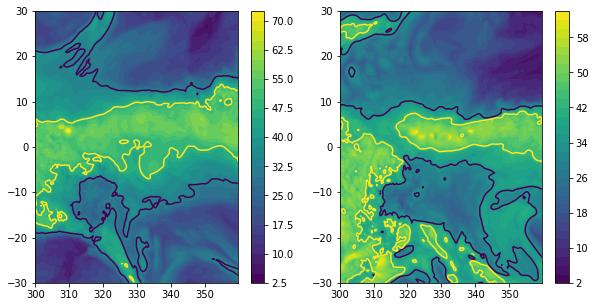

In [80]:
plt.figure(figsize=(10,5))
plt.subplot(121)
ind_test = np.argmin(L_CONTOUR['%i'%year])
plt.contourf(lonAtl, latAtl, PWAtl_np[ind_test, :,:], 30)
plt.colorbar()
plt.contour(lonAtl, latAtl, PWAtl_np[ind_test,:,:], levels = [np.percentile(PWAtl_np[ind_test,:,:], 50), np.percentile(PWAtl_np[ind_test,:,:], per_thresh)])

plt.subplot(122)
ind_test = np.argmax(L_CONTOUR['%i'%year])
plt.contourf(lonAtl, latAtl, PWAtl_np[ind_test, :,:], 30)
plt.colorbar()
plt.contour(lonAtl, latAtl, PWAtl_np[ind_test,:,:], levels = [np.percentile(PWAtl_np[ind_test,:,:], 50), np.percentile(PWAtl_np[ind_test,:,:], per_thresh)])